In [1]:
import pickle
import numpy as np
from skimage import exposure
from PIL import Image
from itertools import product
from sklearn.preprocessing import scale
from scipy.ndimage import filters
import matplotlib.pyplot as plt
import glob
%matplotlib inline

# Feature extraction

In [2]:
def read(subdir='./', prefs=[]): 
    patterns = ['/'.join(['.', 'data', subdir, pref + '*.jpg']) for pref in prefs]
    paths = [sorted(glob.glob(pattern)) for pattern in patterns]
    return [[np.asarray(Image.open(file).convert('L')) / 255. 
             for file in files] 
            for files in paths]

In [3]:
def preprocessing(img):
    img = exposure.equalize_adapthist(img)
    img = img - filters.gaussian_filter(img, 120)
    shape = img.shape
    img = scale(img.reshape(-1)).reshape(shape[0], -1)
    return img / (max(img.max(), abs(img.min())))

In [4]:
batches = read('train', ['base', 'soft'])
batches = [[preprocessing(img) for img in batch] for batch in batches]
batches += [[origin - soft for origin, soft in zip(batches[0], batches[1])]]
masks = read('train', ['mask'])[0]

/usr/local/lib/python3.5/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


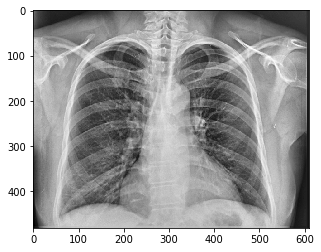

In [5]:
plt.imshow(batches[0][-1])
plt.gray()

In [6]:
def convolve(img, sigma, max_order=3):
    max_order += 1
    filtered = []
    for x in range(max_order):
        for y in range(max_order - x):
            filtered += [filters.gaussian_filter(img, sigma, order=(x, y))]
    return filtered

In [7]:
def convolve_trained(img, kernels):
    filtered = []
    for x in kernels:
        filtered += [filters.convolve(np.asarray(img), x)]
    return filtered

In [8]:
best = pickle.load(open('./data/kernels/good.pkl', 'rb'))

In [9]:
args = [1, 2, 4, 8, 16, 32]
conv = convolve

origins = [np.asarray([conv(img, arg) 
                        for arg in args])
            for img in batches[0]] 

origins = [imgs.reshape(np.shape(imgs)[0] * np.shape(imgs)[1], 
                         np.shape(imgs)[2], np.shape(imgs)[3]).tolist()
            for imgs in origins] 

args = best
conv = convolve_trained

origins = [np.asarray([img] + x + conv(img, args))
            for x, img in zip(origins, batches[0])] 

In [10]:
np.shape(origins[0])

(142, 481, 610)

In [11]:
def generate_smples(origins, bones, softs, masks):
    X = []
    y_bone = []
    y_soft = []
    idxs = []
    for origin, bone, soft, mask in zip(origins, bones, softs, masks):
        idxs += [np.where(mask == 1.0)]
        X += np.asarray([img[idxs[-1]] for img in origin]).T.tolist()
        y_bone += bone[idxs[-1]].tolist()
        y_soft += soft[idxs[-1]].tolist()
        
    return np.asarray(X), np.asarray(y_bone), np.asarray(y_soft), idxs

In [12]:
X, y_bone, y_soft, idxs = generate_smples(origins[:-1], batches[1][:-1], batches[2][:-1],  masks[:-1])
X_test, y_bone_test, y_soft_test, idxs_test = \
generate_smples(origins[-1:], batches[1][-1:], batches[2][-1:],  masks[-1:])

In [13]:
pickle.dump(X, open(r'./out/features.pkl', 'wb'))
pickle.dump(y_bone, open(r'./out/response_bone.pkl', 'wb'))
pickle.dump(y_soft, open(r'./out/response_soft.pkl', 'wb'))
pickle.dump(idxs, open(r'./out/indexes.pkl', 'wb'))

In [14]:
pickle.dump(X_test, open(r'./out/features_test.pkl', 'wb'))
pickle.dump(y_bone_test, open(r'./out/response_bone_test.pkl', 'wb'))
pickle.dump(y_soft_test, open(r'./out/response_soft_test.pkl', 'wb'))
pickle.dump(idxs_test, open(r'./out/indexes_test.pkl', 'wb'))

# Linear-Linear Transformation

In [15]:
from sklearn.cluster import KMeans 
import fastcluster
from sklearn.decomposition import PCA 
from sklearn.preprocessing import RobustScaler
import pandas as pd
import os
import pandas as pd
import re
from sklearn.neighbors import KNeighborsRegressor
from scipy.spatial.distance import cdist

In [16]:
X = pickle.load(open(r'./out/features.pkl', 'rb'))
y_bone = pickle.load(open(r'./out/response_bone.pkl', 'rb'))
y_soft = pickle.load(open(r'./out/response_soft.pkl', 'rb'))
idxs = pickle.load(open(r'./out/indexes.pkl', 'rb'))

In [17]:
X = scale(X)
Y = y_bone
k = 101
d = 18
dim = 60

In [18]:
M = np.zeros((dim,dim))

for i, x in enumerate(X):
    idx = np.argpartition(cdist([x], X, "sqeuclidean")[0], k)
    neighborhood = X[idx[:k]]
    y = Y[idx[:k]]
    x_mean = neighborhood.mean(0)
    y_mean = y.mean()
    B = sum([np.dot((el - x_mean).reshape(el.shape[0], 1), 
                    np.reshape(el - x_mean, (1, -1))) 
             for el in neighborhood])
    B = np.linalg.inv(B)
    response = np.dot(B, sum([x * (el - y_mean) for x, el in zip(neighborhood, y)]))
    M += np.dot(response, response.T)
    if i % 20000 == 0:
        print(i)

0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
360000
380000
400000


In [20]:
e, v = np.linalg.eig(M)
e = e[:d].astype(float)
v = v[:d].astype§(float)
e = (abs(e) ** 0.5) / np.linalg.norm(v, axis=1)
v = np.asarray([i * j for i, j in zip(e, v)])

In [21]:
pickle.dump(M, open(r'./out/matrix_of_reductions.pkl', 'wb'))
pickle.dump(v, open(r'./out/matrix_transform.pkl', 'wb'))

# Training and Testing

In [22]:
import xgboost as xgb

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
v = pickle.load(open(r'./out/matrix_transform.pkl', 'rb'))

In [24]:
X = pickle.load(open(r'./out/features.pkl', 'rb'))
y_bone = pickle.load(open(r'./out/response_bone.pkl', 'rb'))
y_soft = pickle.load(open(r'./out/response_soft.pkl', 'rb'))
idxs = pickle.load(open(r'./out/indexes.pkl', 'rb'))

In [25]:
X_test = pickle.load(open(r'./out/features_test.pkl', 'rb'))
y_bone_test = pickle.load(open(r'./out/response_bone_test.pkl', 'rb'))
y_soft_test = pickle.load(open(r'./out/response_soft_test.pkl', 'rb'))
idxs_test = pickle.load(open(r'./out/indexes_test.pkl', 'rb'))

In [26]:
X = np.dot(scale(X), v.T)
X_test = np.dot(scale(X_test), v.T)

ValueError: shapes (417695,142) and (60,18) not aligned: 142 (dim 1) != 60 (dim 0)

In [29]:
y = pd.DataFrame(y_soft)
y_soft_test = pd.DataFrame(y_soft_test)

scaler = RobustScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)
X = pd.DataFrame(X)

In [ ]:
knn = KNeighborsRegressor(51, n_jobs=8, metric='euclidean')
knn.fit(X, y)
predicted = knn.predict(X_test)

In [ ]:
mp = {
        "booster": "gbtree",
        "objective": "reg:linear",
        "eta": 0.01,
        "max_depth": 14,
        "subsample": 0.65,
        "silent": 1,
        "seed": 0,
        "colsample_bytree": 0.82, 
        "n_estimators": 5000
    }
    
data = xgb.DMatrix(X, y)
model = xgb.train(params=mp, dtrain=data, num_boost_round=1600)